In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Сверточный автокодировщик

In [2]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-4, l2=0.):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [6]:
model = Autoencoder()
max_epochs = 26
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0675
Epoch:2, Loss:0.0376
Epoch:3, Loss:0.0206
Epoch:4, Loss:0.0121
Epoch:5, Loss:0.0088
Epoch:6, Loss:0.0082
Epoch:7, Loss:0.0063
Epoch:8, Loss:0.0064
Epoch:9, Loss:0.0055
Epoch:10, Loss:0.0053
Epoch:11, Loss:0.0047
Epoch:12, Loss:0.0044
Epoch:13, Loss:0.0040
Epoch:14, Loss:0.0036
Epoch:15, Loss:0.0034
Epoch:16, Loss:0.0039
Epoch:17, Loss:0.0040
Epoch:18, Loss:0.0034
Epoch:19, Loss:0.0030
Epoch:20, Loss:0.0031
Epoch:21, Loss:0.0031
Epoch:22, Loss:0.0028
Epoch:23, Loss:0.0025
Epoch:24, Loss:0.0025
Epoch:25, Loss:0.0027
Epoch:26, Loss:0.0025


# Autoencoder reconstructions

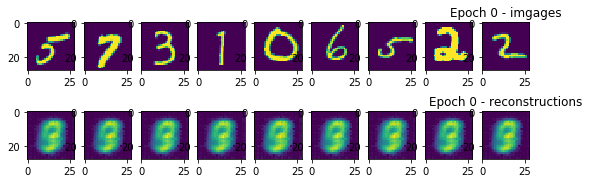

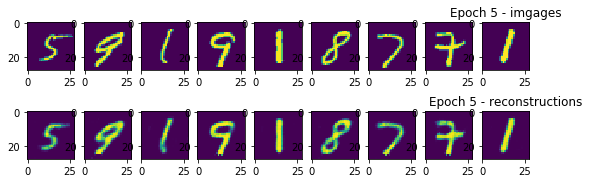

In [121]:
for k in [0, max_epochs-1]:
    plt.figure(figsize=(9, 3))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs[:9]):
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
    plt.title('Epoch {} - imgages'.format(k))
    
    for i, item in enumerate(recon[:9]):
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])
    plt.title('Epoch {} - reconstructions'.format(k))

# Filters (Оптимизация изображения под активацию сверточных нейронов классификатора)

In [34]:
X_test, y_test = next(iter(test_loader))
img = X_test[:1]

conv1_output = model.encoder[0](img)
conv2_output = model.encoder[2](conv1_output)
conv3_output = model.encoder[4](conv2_output)

img_shape = img.shape
conv1_shape = conv1_output.shape
conv2_shape = conv2_output.shape
conv3_shape = conv3_output.shape
print('img shape', img_shape)
print('Conv1 shape', conv1_shape)
print('Conv2 shape', conv2_shape)
print('Conv3 shape', conv3_shape)

model

img shape torch.Size([1, 1, 28, 28])
Conv1 shape torch.Size([1, 16, 14, 14])
Conv2 shape torch.Size([1, 32, 7, 7])
Conv3 shape torch.Size([1, 64, 1, 1])


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [45]:
def generate_pattern(layer):
    
    if layer == 1:
        layer_in = img_shape
        layer_out = conv1_shape
    elif layer == 2:
        layer_in = conv1_shape
        layer_out = conv2_shape
        
    filter_n = layer_out[1]
    filters = []

    for f in range(filter_n):
        img = torch.tensor((np.random.rand(layer_in[0],
                                           layer_in[1],
                                           layer_in[2],
                                           layer_in[3]) - 0.5) / 0.5, dtype=torch.float, requires_grad=True)
        optimizer = optim.Adam([img], lr=5e-3)
        for i in range(40):
            optimizer.zero_grad()
            
            if layer == 1:
                output = model.encoder[0](img)[:, f, :, :]
            elif layer == 2:
                output = model.encoder[2](img)[:, f, :, :]
            loss = -output.mean()
            loss.backward()    
            optimizer.step()

        filters.append(output.detach().numpy())
    
    return filters

Conv1 filters


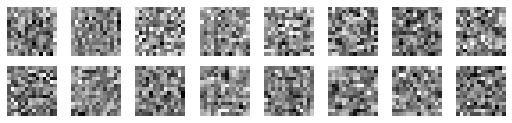

In [46]:
print('Conv1 filters')
filters = generate_pattern(1)

fig = plt.figure(figsize=(9, 2))
for n in range(len(filters)):
    plt.subplot(2, 8, n + 1)
    plt.imshow(filters[n][0, :, :], cmap = matplotlib.cm.binary)
    plt.axis('off')

Conv2 filters


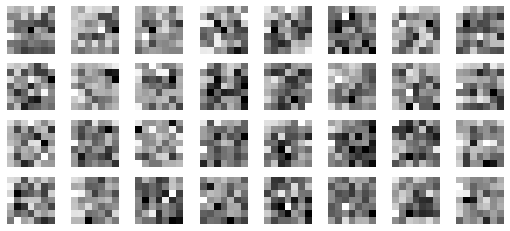

In [47]:
print('Conv2 filters')
filters = generate_pattern(2)

fig = plt.figure(figsize=(9, 4))
for n in range(len(filters)):
    plt.subplot(4, 8, n + 1)
    plt.imshow(filters[n][0, :, :], cmap = matplotlib.cm.binary)
    plt.axis('off')